# Novozymes Enzyme Stability Prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os, glob

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Dependencies and Set Global Var

In [ ]:
import numpy as np
import sklearn
from collections import defaultdict
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from scipy.spatial import transform
from sklearn.preprocessing import OneHotEncoder
feature_label = 1
feature_field = defaultdict(int)

# Load Datasets

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Cosi123 group project/novozymes-enzyme-stability-prediction/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Cosi123 group project/novozymes-enzyme-stability-prediction/test.csv')
train_df_without_datasource = train_df[train_df['data_source'].isnull()]
train_df_with_datasource = train_df[train_df['data_source'].notnull()]

test_df['Length'] = [len(seq) for seq in test_df["protein_sequence"]]
test_df['Length'].mean()

220.9680895151264

# Data Visualization 

# Train_dataset 

In [ ]:
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31390 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            31390 non-null  int64  
 1   protein_sequence  31390 non-null  object 
 2   pH                31104 non-null  float64
 3   data_source       28043 non-null  object 
 4   tm                31390 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


None

1. About 1% (286) of datapoints do not have pH value

2. About 10% (3,347) of datapoints do not have data_source

In [ ]:
display(train_df_without_datasource.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3347 entries, 69 to 30742
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            3347 non-null   int64  
 1   protein_sequence  3347 non-null   object 
 2   pH                3335 non-null   float64
 3   data_source       0 non-null      object 
 4   tm                3347 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 156.9+ KB


None

1. About 12 datapoints do not have data soruce and pH values.

In [ ]:
train_df_with_datasource['tm'].describe()

count    28043.000000
mean        51.372178
std         12.057410
min          0.000000
25%         43.700000
50%         48.700000
75%         54.500000
max        130.000000
Name: tm, dtype: float64

In [ ]:
train_df_without_datasource['tm'].describe()

count    3347.000000
mean       30.506394
std        15.292467
min        -1.000000
25%        22.000000
50%        25.000000
75%        34.600000
max        88.900000
Name: tm, dtype: float64

# Distribution of dataset with and without data_source 

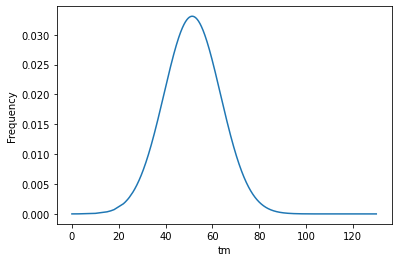

In [ ]:
# Calculating mean and Stdev of tm
df_mean = np.mean(train_df_with_datasource["tm"])
df_std = np.std(train_df_with_datasource["tm"])
 
# Calculating probability density function (PDF)
pdf = stats.norm.pdf(train_df_with_datasource["tm"].sort_values(), df_mean, df_std)

# Drawing a graph
plt.plot(train_df_with_datasource["tm"].sort_values(), pdf)
plt.xlabel("tm")    
plt.ylabel("Frequency")                
plt.show()

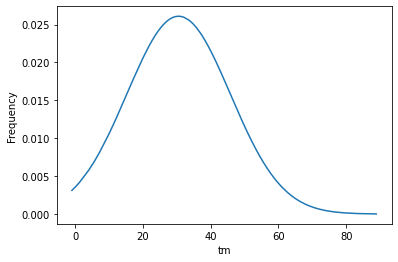

In [ ]:
# Calculating mean and Stdev of tm
df_mean = np.mean(train_df_without_datasource["tm"])
df_std = np.std(train_df_without_datasource["tm"])
 
# Calculating probability density function (PDF)
pdf = stats.norm.pdf(train_df_without_datasource["tm"].sort_values(), df_mean, df_std)

# Drawing a graph
plt.plot(train_df_without_datasource["tm"].sort_values(), pdf)
plt.xlabel("tm")    
plt.ylabel("Frequency")                
plt.show()

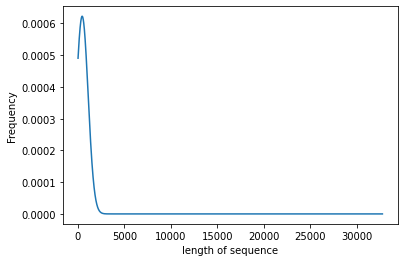

In [ ]:
lengths_of_sequence = []
train_df2 = train_df.copy()

for seq in train_df2['protein_sequence']:
    lengths_of_sequence.append(len(seq))
train_df2['len_of_seq'] = lengths_of_sequence

# Calculating mean and Stdev of tm
df_mean = np.mean(train_df2['len_of_seq'])
df_std = np.std(train_df2['len_of_seq'])
 
# Calculating probability density function (PDF)
pdf = stats.norm.pdf(train_df2['len_of_seq'].sort_values(), df_mean, df_std)

# Drawing a graph
plt.plot(train_df2['len_of_seq'].sort_values(), pdf)
plt.xlabel("length of sequence")    
plt.ylabel("Frequency")                
plt.show()

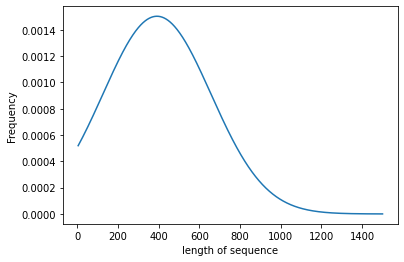

In [ ]:
max_length = 1500
train_df2 = train_df2[train_df2['len_of_seq']<=max_length]
# Calculating mean and Stdev of tm
df_mean = np.mean(train_df2['len_of_seq'])
df_std = np.std(train_df2['len_of_seq'])
 
# Calculating probability density function (PDF)
pdf = stats.norm.pdf(train_df2['len_of_seq'].sort_values(), df_mean, df_std)

# Drawing a graph
plt.plot(train_df2['len_of_seq'].sort_values(), pdf)
plt.xlabel("length of sequence")    
plt.ylabel("Frequency")                
plt.show()

We can see that the distribution of the datapoint without data_source is not drasitically different from the distribution of the datapoint with data_source. Thus, we decided to keem them in the train set.

# Approch1: make each letter of the sequence becomes a new feature, loss sequence information. 

In [ ]:
train_df1 = train_df.copy()
train_df1.drop(['data_source'],axis=1,inplace=True)
train_df1['pH'] = train_df1['pH'].fillna(train_df1['pH'].mean())

In [ ]:
import seaborn as sns
sns.heatmap(train_df1.corr(),linewidths=1,cmap=plt.cm.Reds, annot=True);

plt.title('Heatmap for correlation between columns of training data')

In [ ]:
#prepare train data
import re
search_amino=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
for amino_acid in search_amino:
     train_df1[amino_acid]=train_df['protein_sequence'].str.count(amino_acid,re.I)


In [ ]:
train_df1.drop(['protein_sequence'],axis=1,inplace=True)
train_df1

In [ ]:
#prepare test data
test_df1 = test_df.copy()
for amino_acid in search_amino:
     test_df1[amino_acid]=test_df['protein_sequence'].str.count(amino_acid,re.I)


In [ ]:
test_df1.drop(['data_source','protein_sequence'],axis=1,inplace=True)

In [ ]:
#split x and y in train data
x=train_df1.drop(['tm'],axis=1)
y=train_df1['tm']

In [ ]:
#split x_train, x_valid, y_train, y_valid
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid=train_test_split(x,y,test_size=0.20,random_state=42)

In [ ]:
from scipy.stats import randint

random_grid={'max_depth':list(np.arange(10, 100, step=10)),
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':randint(1,7),
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }

RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
# Use the random grid to search for best hyperparameters
#create the base model to tune
rf = RandomForestRegressor(random_state = 42)
rf.fit(x_train, y_train)
print('Random Forest Score', rf.score(x_valid, y_valid))
# Random search of parameters, using 3 fold cross validation, 
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
#                               n_iter = 50, scoring='neg_mean_absolute_error', 
#                               cv =3, verbose=2, random_state=42, n_jobs=-1,
#                               return_train_score=True)

# Fit the random search model
# rf_random.fit(x_train,y_train)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                'subsample'    : [0.9, 0.5, 0.2, 0.1],
                'n_estimators' : [100,500,1000, 1500],
                'max_depth'    : [4,6,8,10]
              }
GBR = GradientBoostingRegressor()
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(x_train, y_train)
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=500, subsample=0.5)
GBR.fit(x_train, y_train)
y_pred = GBR.predict(x_valid)

In [ ]:
GBR.score(x_valid,y_valid)

In [ ]:
output = GBR.predict(test_df1)
df=pd.DataFrame(test_df1['seq_id'])
df['tm'] = output
df.to_csv('/content/drive/MyDrive/Cosi123 group project/submission_GBR.csv',index=False)

# Approch2: OneHot encoding and padding


In [ ]:
search_amino= [['A'],['C'],['D'],['E'],['F'],['G'], ['H'], ['I'], ['K'], ['L'], ['M'], ['N'], ['P'], ['Q'], ['R'], ['S'], ['T'], ['V'], ['W'], ['Y']]
s=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
pad = []
dic = {}
enc = OneHotEncoder()
transformed = enc.fit_transform(search_amino).toarray()
for i in range(len(s)):
  dic[s[i]] = transformed[i]
  pad.append(0)

In [ ]:
train_df2


,seq_id,protein_sequence,pH,data_source,tm,len_of_seq
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7,341
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5,286
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5,497
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2,265
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5,1451
...,...,...,...,...,...,...
31385,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,doi.org/10.1038/s41592-020-0801-4,51.8,549
31386,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,doi.org/10.1038/s41592-020-0801-4,37.2,469
31387,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,doi.org/10.1038/s41592-020-0801-4,64.6,128
31388,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.7,593


In [ ]:
encoded_sequences = []
x = list(train_df2['protein_sequence'])
for i in range(train_df2.shape[0]):
# for i in range(10000):
  seq = x[i]
  l = []
  for acid in seq:
    l.append(dic[acid])
  for i in range(max_length - len(seq)):
    l.append(pad)
  encoded_sequences.append(np.array(l))
encoded_sequences = np.array(encoded_sequences)
encoded_sequences.shape

NameError: ignored

#Approach 3: OneHotEncoding and Translating

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder

# reading csv files
data =  pd.read_csv('train.csv')
# print(data)
np_data = np.array(data,dtype=object)
DNA = np_data[:,1]
ph = np_data[:,2]
tm = np_data[:,4]


def split(x):
    ans = []
    for i in x:
        ans.append(i)
    return ans



def transform(x):
    matrix = []
    row = []
    for i in x:
        for j in i:
            row.append(j)
        matrix.append(row)
        row = []
    return matrix



def stack(A,B):
    ans = []
    row = []
    for i in range(len(B)):
        for j in A[i]:
            row.append(j)
        row.append(B[i])
        print(row)
        ans.append(row)
    return ans

# print(DNA)
A = np.array(transform(DNA),dtype=object)
# print(A[0])
np.savetxt("A.csv", A,fmt='%s')
DNAph = stack(A, ph)

print(DNAph[0])
# print(DNAph)



enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(DNAph)
transformed = enc.transform(DNAph).toarray()
print(transformed)


# Final Approach: Using Rapid protein stability prediction model to get the thermodynamic stability changes and apply to our test data.

Use this [Colab](https://colab.research.google.com/github/KULL-Centre/papers/blob/main/2022/ML-ddG-Blaabjerg-et-al/RaSPLab.ipynb#scrollTo=Q8szWTVF-dXB) to generate the thermodynamic stability changes of all proteins. Use the "wildtype_structure_prediction_af2.pdb" file in kaggle as input, output file is 'cavity_pred_CUSTOM_A.csv' which we will use later.

In [ ]:
!pip install Levenshtein

In [ ]:
import Levenshtein
def gen_mutations(name, df,
                  wild="VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQ""RVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGT""NAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKAL""GSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK"):
    result = []
    for _, r in df.iterrows():
        ops = Levenshtein.editops(wild, r.protein_sequence)
        assert len(ops) <= 1
        if len(ops) > 0 and ops[0][0] == 'replace':
            idx = ops[0][1]
            result.append([ops[0][0], idx + 1, wild[idx], r.protein_sequence[idx]])
        elif len(ops) == 0:
            result.append(['same', 0, '', ''])
        elif ops[0][0] == 'insert':
            assert False, "Ups"
        elif ops[0][0] == 'delete':
            idx = ops[0][1]
            result.append(['delete', idx + 1, wild[idx], '-'])
        else:
            assert False, "Ups"

    df = pd.concat([df, pd.DataFrame(data=result, columns=['op', 'idx', 'wild', 'mutant'])], axis=1)
    df['mut'] = df[['wild', 'idx', 'mutant']].astype(str).apply(lambda v: ''.join(v), axis=1)
    df['name'] = name
    return df


df_test = gen_mutations('wildtypeA', pd.read_csv('/content/drive/MyDrive/Cosi123 group project/novozymes-enzyme-stability-prediction/test.csv'))
df_test.to_csv('/content/drive/MyDrive/Cosi123 group project/test_data.csv')

In [ ]:
all = pd.read_csv('/content/drive/MyDrive/Cosi123 group project/cavity_pred_CUSTOM_A.csv')
target = df_test.copy()
target['res']=pd.Series() 
variant = list(all['variant'])
score = all['score_ml']
mut=list(target['mut'])
res = list()
missing=list()
mean = np.mean(score)
for i in range(len(mut)):
    added = False
    for j in range(len(variant)):
        if mut[i]==variant[j]:
            res.append(score[j]*(-1))
            added = True
            break
    if added==False:
        missing.append(i)
        res.append(mean)
print(len(res))
print('missing:', len(missing))
submission = pd.read_csv('/content/drive/MyDrive/Cosi123 group project/novozymes-enzyme-stability-prediction/sample_submission.csv')
submission['tm']=res
submission['tm']
submission.to_csv('/content/drive/MyDrive/Cosi123 group project/submission_mut.csv',index=False)